In [1]:
import numpy as np
import random
import itertools as it
from sympy.combinatorics import Permutation
import gymnasium as gym
from gymnasium import spaces



COLOR_MAP = {
    "W" :0,
    "G" :1,
    "R" :2,
    "B" :3,
    "O" :4,
    "Y" :5
    }

FACES = ["WWWW", "GGGG", "RRRR", "BBBB", "OOOO", "YYYY"]
SOLVED_STATE_COLOR = [''.join(faces) for faces in it.permutations(FACES)]
SOLVED_STATE_INDEX = np.empty((720,24))

for i,s in enumerate(SOLVED_STATE_COLOR):
    for j,c in enumerate(s):
        SOLVED_STATE_INDEX[i,j] = COLOR_MAP[c]

class Cube2x2Env(gym.Env):

    def __init__(self):
        self.move_count = 0
        self._action_to_move = {
            0: Permutation(23)(2, 19, 21, 8)(3, 17, 20, 10)(4, 6, 7, 5),
            1: Permutation(0, 18, 23, 9)(1, 16, 22, 11)(12, 13, 15, 14),
            2: Permutation(1, 5, 21, 14)(3, 7, 23, 12)(8, 10, 11, 9),
            3: Permutation(23)(0, 4, 20, 15)(2, 6, 22, 13)(16, 17, 19, 18),
            4: Permutation(6, 18, 14, 10)(7, 19, 15, 11)(20, 22, 23, 21),
            5: Permutation(23)(0, 1, 3, 2)(4, 16, 12, 8)(5, 17, 13, 9)
        }

        self.steps_from_solved = 1
        
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Box(0, 5, shape=(24,), dtype=np.uint8)
   
        self.state = self.scramble()

    def step(self, action):
        truncated = False
        move = self._action_to_move[action]
        self.state = move(self.state)
        self.move_count += 1
        # Calculate reward
        if np.any(np.all(self.state == SOLVED_STATE_INDEX, axis=1)): 
            reward = 1000
            done = True
        else: 
            done = False
            reward = -1 
        
        if self.move_count > 1000:
            truncated = True
        # Return step information
        return np.array(self.state), reward, done, truncated, {}
    
    def scramble(self):
        state = SOLVED_STATE_INDEX[0]
        for i in range(self.steps_from_solved):
            move = self._action_to_move[random.randint(0,5)]
            state = move(state)
        if np.any(np.all(state == SOLVED_STATE_INDEX, axis=1)):
            self.scramble()
        return np.array(state, dtype=np.uint8)
    
    def reset(self, seed=None):
        # Reset shower temperature
        self.state = self.scramble()
        # Reset shower time
        self.move_count = 0 
        return self.state, {}


        

    def __repr__(self):
        ascii = '''
         +--------+                    
         | {0}    {1} |                    
         |   d1   |                    
         | {2}    {3} |                    
+--------+--------+--------+--------+  
| {16}    {17} | {4}    {5} | {8}    {9} | {12}    {13} |  
|   r1   |   f0   |   r0   |   f1   |  
| {18}    {19} | {6}    {7} | {10}    {11} | {14}    {15} |  
+--------+--------+--------+--------+  
         | {20}    {21} |                    
         |   d0   |                    
         | {22}    {23} |                    
         +--------+                    

      '''
        return ascii.format(*self.state)
        


In [2]:
env = Cube2x2Env()

# Create the neural network

In [3]:
import torch

W1 = torch.randn(24,72)
B1 = torch.randn(1,72)
W2 = torch.randn(72,72)
B2 = torch.randn(1,72)
W3 = torch.randn(72,6)
B3 = torch.randn(1,6)

W1_HAT = W1
B1_HAT = B1
W2_HAT = W2
B2_HAT = B2
W3_HAT = W3
B3_HAT = B3

q_parameters = [W1, B1, W2, B2, W3, B3]
for p in q_parameters:
  p.requires_grad = True
  
q_hat_parameters = [W1_HAT, B1_HAT, W2_HAT, B2_HAT, W3_HAT, B3_HAT]

In [4]:
def q(input_layer):
    layer1 = torch.tanh(input_layer @ W1 + B1)
    layer2 = torch.tanh(layer1 @ W2 + B2)
    logits = layer2 @ W3 + B3
    return logits

def q_hat(input_layer):
    layer1 = torch.tanh(input_layer @ W1_HAT + B1_HAT)
    layer2 = torch.tanh(layer1 @ W2_HAT + B2_HAT)
    logits = layer2 @ W3_HAT + B3_HAT
    return logits

# Hyperparameters

In [5]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
TAU = 1e-3                # Soft update parameter.
MINIBATCH_SIZE = 64     # Mini-batch size.

# Train the agent

In [7]:
import utils
from collections import deque, namedtuple 

num_episodes = 5
max_num_timesteps = 1000

mean_reward = 0
episode_reward_hist = []
steps_len_hist = []
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer with capacity MEMORY_SIZE to store experiences
memory_buffer = deque(maxlen=MEMORY_SIZE)
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

total_step = 0
stepi = []
lossi = []

for i in range(100):
    done = False
    state, info = env.reset()
    
    episode_reward = 0
    steps_len = 0
    reward_hist = []
    for t in range(max_num_timesteps):
        state_tensor = torch.tensor(state, dtype=torch.float)
        q_values = q(state_tensor)

        # picking an action with an ε-greedy policy
        if random.random() > epsilon:
            action = torch.argmax(q_values.numpy()[0])
        else:
            action = random.choice(torch.arange(6))

        next_state, reward, done, truncated, _ = env.step(action.item())

        memory_buffer.append(experience(state_tensor, action, reward, next_state, done))

        if (t + 1) % NUM_STEPS_FOR_UPDATE == 0 and len(memory_buffer) > MINIBATCH_SIZE:
            minibatch = random.sample(memory_buffer, k=MINIBATCH_SIZE)

            states, actions, rewards, next_states, done_vals = utils.extract_experiences(memory_buffer, MINIBATCH_SIZE)

            # forward pass for mini-batch
            max_q_hat = torch.max(q_hat(next_states), axis=1).values  # we're only taking the value of the best possible action according to Q^ 

            y_preds = rewards + (1 - done_vals) * GAMMA * max_q_hat

            # get the Q networks values 
            action_indices = torch.tensor([[a.item()] for a in actions],dtype=torch.int64) # we're only taking Q-network predicted value for the action that has been taken
            q_values = q(states).gather(1, action_indices).reshape(5,)    

            # calculate the loss
            loss = torch.sum((y_preds - q_values)**2)/MINIBATCH_SIZE

            # reset the parameters' gradient before performing the backward pass
            for p in q_parameters:
                p.grad = None
            loss.backward()

            # update Q and Q^ parameters
            for p, p_hat in zip(q_parameters, q_hat_parameters):
                p.data += -ALPHA * p.grad
                p_hat = TAU * p + (1.0 - TAU) * p_hat

            stepi.append(total_step)
            lossi.append(loss.log10().item())
        total_step += 1
        steps_len += 1
        episode_reward += reward

        if done:
            break


        
    steps_len_hist.append(steps_len)
    episode_reward_hist.append(episode_reward)


In [ ]:
episode_reward_hist

[-1000, -1000, -1000, -1000, -1000, -1000, 1000, -1000, 1000, -1000]

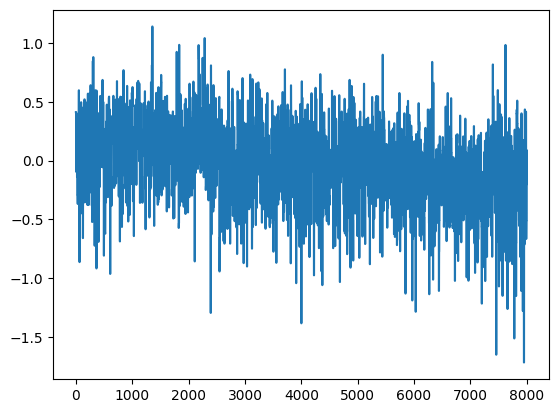

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(stepi, lossi);